# Cycling: weather, COVID and brown fat
## Data cleaning and preparation
Import the TfL cycling data. Check for duplicates and null values, which are removed.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [29]:
trip_df = pd.read_excel("datasets/Central London (area).xlsx")
trip_df.head()

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6,0,0.0,0.0,0
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6,15,15.0,0.0,15
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6,30,35.0,0.0,35
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6,45,59.0,2.0,61
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),2014-01-24 00:00:00,Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7,0,73.0,0.0,73


In [30]:
print(trip_df.duplicated().value_counts())
trip_df.isnull().sum()

False    758163
dtype: int64


Survey wave (calendar quarter)        0
Equivalent financial quarter          0
Site ID                               0
Location                              0
Survey date                       10156
                                  ...  
Start hour                            0
Start minute                          0
Number of private cycles             64
Number of cycle hire bikes           64
Total cycles                          0
Length: 14, dtype: int64

In [31]:
trip_df = trip_df.dropna()
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743317 entries, 0 to 758162
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Survey wave (calendar quarter)  743317 non-null  object 
 1   Equivalent financial quarter    743317 non-null  object 
 2   Site ID                         743317 non-null  object 
 3   Location                        743317 non-null  object 
 4   Survey date                     743317 non-null  object 
 5   Weather                         743317 non-null  object 
 6   Time                            743317 non-null  object 
 7   Period                          743317 non-null  object 
 8   Direction                       743317 non-null  object 
 9   Start hour                      743317 non-null  int64  
 10  Start minute                    743317 non-null  int64  
 11  Number of private cycles        743317 non-null  float64
 12  Number of cycle 

The survey date needs to be a datetime object and some columns can be removed.

In [32]:
trip_df['Survey date'] = pd.to_datetime(trip_df['Survey date'], errors='coerce')
trip_df['Survey date'].isnull().sum()

#Produced 256 instances of NaT
trip_df['Survey date'] = trip_df['Survey date'].dropna()

trip_df = trip_df.drop(['Equivalent financial quarter', 'Site ID', 'Location', 'Direction'], axis=1)

To make the data more useable I'll change the "Survey wave" column into <br>
a "Quarter" integer and add "Year" and "Is_weekday" columns.

In [33]:
trip_df.rename(columns={'Survey wave (calendar quarter)': 'Quarter'}, inplace=True)
trip_df['Quarter'] = trip_df['Quarter'].str.extract('\\sQ([0-9])')

trip_df['Year'] = trip_df['Survey date'].dt.year
trip_df['Is_weekday'] = (trip_df['Survey date'].dt.weekday < 5).astype(int)

trip_df.head()

,Quarter,Survey date,Weather,Time,Period,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Year,Is_weekday
0,1,2014-01-24,Dry,0600 - 0615,Early Morning (06:00-07:00),6,0,0.0,0.0,0,2014.0,1
1,1,2014-01-24,Dry,0615 - 0630,Early Morning (06:00-07:00),6,15,15.0,0.0,15,2014.0,1
2,1,2014-01-24,Dry,0630 - 0645,Early Morning (06:00-07:00),6,30,35.0,0.0,35,2014.0,1
3,1,2014-01-24,Dry,0645 - 0700,Early Morning (06:00-07:00),6,45,59.0,2.0,61,2014.0,1
4,1,2014-01-24,Dry,0700 - 0715,AM peak (07:00-10:00),7,0,73.0,0.0,73,2014.0,1


There are 282 different weather descriptors used in the TfL data. With the large<br>
dataset I can ignore the little used (sub 200 count) descriptors and change<br>
the rest to either 'Wet' or 'Dry'. I omitted anything ambiguous also.<br>
I then chnaged 'Weather' to a more useful boolean value: 0: dry, 1: wet

In [34]:
pd.set_option('display.max_rows', 12)
print('Number of weather labels:', (trip_df['Weather'].nunique()))
print('Number of records:', trip_df['Weather'].value_counts().sum())
print(trip_df['Weather'].value_counts())

Number of weather labels: 282
Number of records: 743317
Dry                   618381
Wet                    77522
Fine                   18846
Rain                    5408
Cloudy                  4394
                       ...  
Wet And Very Windy         2
Drizzle/rain               2
Shower/wet                 2
Deluge                     2
Windy/cloudy               2
Name: Weather, Length: 282, dtype: int64


In [35]:
trip_df['Weather'] = trip_df['Weather'].replace({'Rain': 'Wet', 'Drizzle': 'Wet', 'Light Rain': 'Wet', 'Wet ': 'Wet', 'Cold/rain': 'Wet', 'Lt Rain': 'Wet', 'Rain/wind': 'Wet'})
trip_df['Weather'] = trip_df['Weather'].replace({'Fine': 'Dry', 'Cloudy': 'Dry', 'Sunny': 'Dry', 'Fair': 'Dry', 'Dry/sunny': 'Dry', 'Windy': 'Dry', 'Cold': 'Dry', 'Dry/hot': 'Dry'})
print(trip_df['Weather'].value_counts())

Dry                    646359
Wet                     86148
Damp                      639
Wet/dry                   422
Dry/wet                   298
                        ...  
Road Drying Sun Out         2
Drizzle/rain                2
Cloudy/drizzle              2
Dry 3/4 Dry                 2
Fine (windy)                2
Name: Weather, Length: 267, dtype: int64


In [36]:
trip_df['Weather'] = trip_df['Weather'].replace({'Dry': int(0), 'Wet': int(1)})
trip_df['Weather'] = pd.to_numeric(trip_df['Weather'], errors='coerce')
trip_df=trip_df.dropna(subset=['Weather'])
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732507 entries, 0 to 758162
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Quarter                     732507 non-null  object        
 1   Survey date                 732251 non-null  datetime64[ns]
 2   Weather                     732507 non-null  float64       
 3   Time                        732507 non-null  object        
 4   Period                      732507 non-null  object        
 5   Start hour                  732507 non-null  int64         
 6   Start minute                732507 non-null  int64         
 7   Number of private cycles    732507 non-null  float64       
 8   Number of cycle hire bikes  732507 non-null  float64       
 9   Total cycles                732507 non-null  int64         
 10  Year                        732251 non-null  float64       
 11  Is_weekday                  732507 non-

     Year  Total cycles  Total cycles (thousands)
0  2014.0       1565443                  1565.443
1  2015.0       1578059                  1578.059
2  2016.0       1693199                  1693.199
3  2017.0       1672452                  1672.452
4  2018.0       1835579                  1835.579


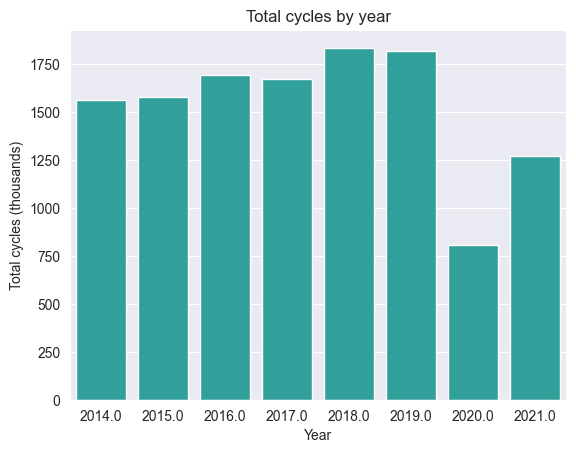

In [11]:
# Check how much variance there is by year
trip_df_grouped = trip_df.groupby('Year')['Total cycles'].sum().reset_index()
trip_df_grouped['Total cycles (thousands)'] = trip_df_grouped['Total cycles'] / 1000
sns.light_palette("seagreen")
sns.barplot(x='Year', y='Total cycles (thousands)', data=trip_df_grouped, color="lightseagreen")
plt.title('Total cycles by year')
print(trip_df_grouped.head())
# It's clear the difference COVID made

In [12]:
#I'll calculate the yearly totals for 2019 and 2020 to compare with figures for the Underground passenger numbers
print('Total cycles 2019:', trip_df_grouped['Total cycles'][trip_df_grouped['Year'] == 2019])
print('Total cycles 2020:', trip_df_grouped['Total cycles'][trip_df_grouped['Year'] == 2020])


Total cycles 2019: 5    1818402
Name: Total cycles, dtype: int64
Total cycles 2020: 6    806774
Name: Total cycles, dtype: int64


This is a drop of 55.6%. 
London Underground passenger journeys dropped from 1,337 million in financial year 2019/20 to 296.1m in 2020/21 – a 77.9% drop Source TfL via Statista https://www.statista.com/statistics/304852/passenger-journeys-on-the-london-underground/

Text(0.5, 1.0, 'Total cycles by quarter')

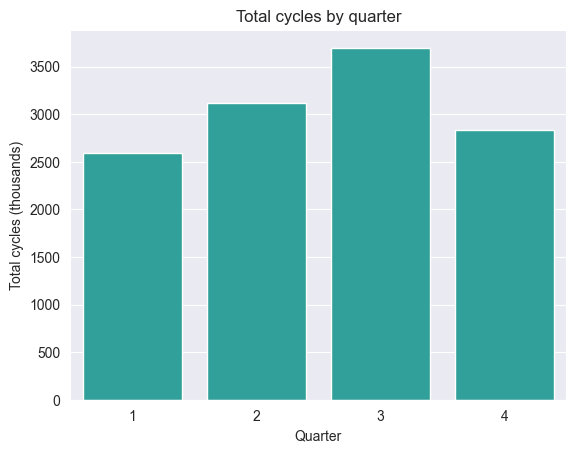

In [13]:
# Now let's see what variance there is by season

trip_df_grouped = (trip_df.groupby('Quarter')['Total cycles'].sum().reset_index())
trip_df_grouped['Total cycles (thousands)'] = trip_df_grouped['Total cycles'] / 1000
sns.barplot(x='Quarter', y='Total cycles (thousands)', data=trip_df_grouped, color="lightseagreen")
plt.title('Total cycles by quarter')

#Looks as expected. 


In [14]:
# Load weather data.

weather_df = pd.read_csv('datasets/hourly_weather.csv')
weather_df.head()


,time,temperature,relative_humidity,precipitation,weathercode
0,2014-01-24T00:00,1.4,90,0.0,1
1,2014-01-24T01:00,0.9,92,0.0,2
2,2014-01-24T02:00,0.4,93,0.0,3
3,2014-01-24T03:00,0.1,94,0.0,2
4,2014-01-24T04:00,0.2,95,0.0,3


In [15]:
#I'm going to remove the weathercode as the TfL data includes wet and dry info


weather_df = weather_df.drop(['weathercode'], axis= 1)
weather_df['time'] = pd.to_datetime(weather_df['time'])




In [16]:
#I'm only interested in the morning peak (when most decisions about commuting by bike are made) 
#and will use the temp for 8am

weather_df_filtered = weather_df.loc[weather_df['time'].dt.hour == 8].copy()
weather_df_filtered['time'] = weather_df_filtered['time'].dt.floor('d')

weather_df_filtered.rename(columns= {'time': 'Survey date'}, inplace=True)

#I'm going to create a column rounding temperatures to the nearest integer for plotting later
weather_df_filtered['temp_integer'] = weather_df_filtered['temperature'].round().astype(int)
weather_df_filtered.head()

,Survey date,temperature,relative_humidity,precipitation,temp_integer
8,2014-01-24,1.4,97,0.0,1
32,2014-01-25,7.1,99,0.0,7
56,2014-01-26,3.6,87,0.0,4
80,2014-01-27,1.6,86,0.0,2
104,2014-01-28,4.1,92,0.0,4


In [17]:
trip_with_temp = pd.merge(trip_df, weather_df_filtered, on= ['Survey date'])
trip_with_temp.head()



,Quarter,Survey date,Weather,Time,Period,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Year,Is_weekday,temperature,relative_humidity,precipitation,temp_integer
0,1,2014-01-24,0.0,0600 - 0615,Early Morning (06:00-07:00),6,0,0.0,0.0,0,2014.0,1,1.4,97,0.0,1
1,1,2014-01-24,0.0,0615 - 0630,Early Morning (06:00-07:00),6,15,15.0,0.0,15,2014.0,1,1.4,97,0.0,1
2,1,2014-01-24,0.0,0630 - 0645,Early Morning (06:00-07:00),6,30,35.0,0.0,35,2014.0,1,1.4,97,0.0,1
3,1,2014-01-24,0.0,0645 - 0700,Early Morning (06:00-07:00),6,45,59.0,2.0,61,2014.0,1,1.4,97,0.0,1
4,1,2014-01-24,0.0,0700 - 0715,AM peak (07:00-10:00),7,0,73.0,0.0,73,2014.0,1,1.4,97,0.0,1


In [18]:
#We are going to look at just the AM peak period on weekdays
AM_peak_trips = trip_with_temp.loc[(trip_with_temp['Period'] == 'AM peak (07:00-10:00)') & (trip_with_temp['Is_weekday'] == 1)]
AM_peak_trips.describe()

,Weather,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Year,Is_weekday,temperature,relative_humidity,precipitation,temp_integer
count,135768.000000,135768.000000,135768.000000,135768.000000,135768.000000,135768.000000,135768.000000,135768.0,135768.000000,135768.000000,135768.000000,135768.000000
mean,0.118393,8.000206,22.501547,26.803474,3.072955,29.876429,2017.260179,1.0,10.515148,84.272244,0.060580,10.508603
std,0.323074,0.816572,16.770374,40.451999,4.785570,43.976429,2.189646,0.0,5.855272,9.975930,0.232137,5.858363
min,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.0,-6.100000,52.000000,0.000000,-6.000000
25%,0.000000,7.000000,15.000000,4.000000,0.000000,5.000000,2015.000000,1.0,5.900000,77.000000,0.000000,6.000000
50%,0.000000,8.000000,30.000000,13.000000,2.000000,15.000000,2017.000000,1.0,11.000000,86.000000,0.000000,11.000000
75%,0.000000,9.000000,45.000000,32.000000,4.000000,36.000000,2019.000000,1.0,15.300000,93.000000,0.000000,15.000000
max,1.000000,9.000000,45.000000,1177.000000,108.000000,1200.000000,2021.000000,1.0,25.300000,100.000000,3.100000,25.000000


/var/folders/m9/k369lbcn17d83pz89nrk3bz40000gp/T/ipykernel_15249/424732414.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(AM_peak_trips.corr()[["Total cycles"]].sort_values(by="Total cycles", ascending=False)[1:],annot=True)


<AxesSubplot: >

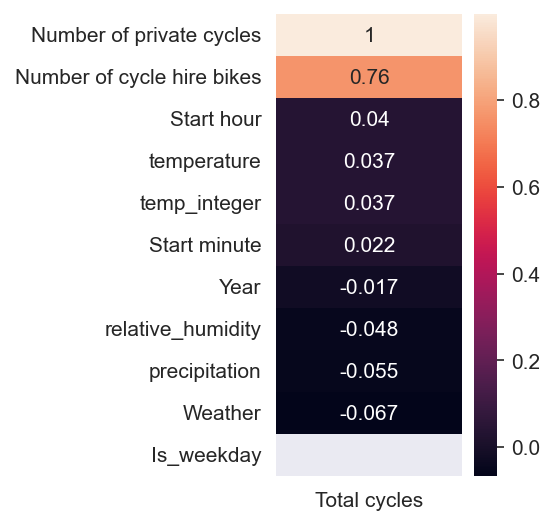

In [19]:
# Let's check the correlation between the target variable 'Total cycles' and the others

plt.figure(figsize=(2,4), dpi=150)
sns.heatmap(AM_peak_trips.corr()[["Total cycles"]].sort_values(by="Total cycles", ascending=False)[1:],annot=True)

The correlations are weak

Text(0.5, 0, 'Temperature at 8am')

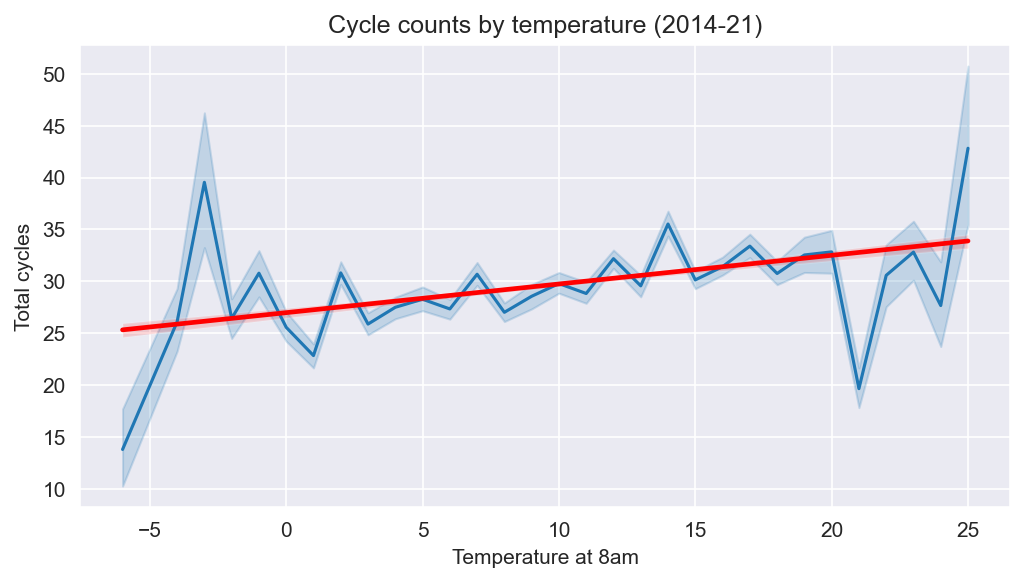

In [20]:
# Plot Total cycles against temperature with the regression line

plt.figure(figsize=(8,4), dpi=150)
plt.title('Cycle counts by temperature (2014-21)')
sns.lineplot(x='temp_integer', y='Total cycles', data=AM_peak_trips)
sns.regplot(x='temp_integer', y='Total cycles', data=AM_peak_trips, scatter=False, color='red')
plt.xlabel('Temperature at 8am')


Text(0.5, 0, 'Temperature at 8am')

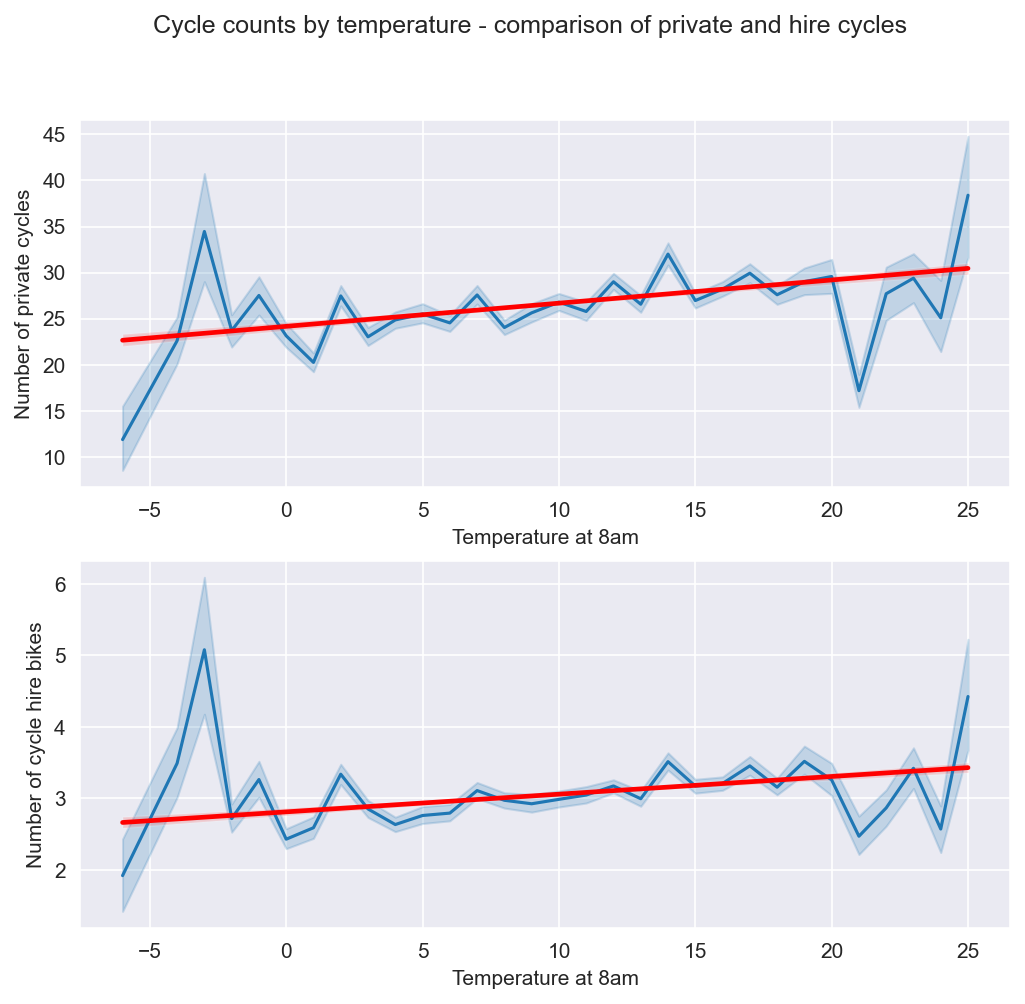

In [21]:
#Compare private and hire bikes

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150)

sns.lineplot(x='temp_integer', y='Number of private cycles', data=AM_peak_trips, ax=axs[0])
sns.regplot(x='temp_integer', y='Number of private cycles', data=AM_peak_trips, scatter=False, color='red', ax=axs[0])
sns.lineplot(x='temp_integer', y='Number of cycle hire bikes', data=AM_peak_trips, ax=axs[1])
sns.regplot(x='temp_integer', y='Number of cycle hire bikes', data=AM_peak_trips, scatter=False, color='red', ax=axs[1])

fig.suptitle('Cycle counts by temperature - comparison of private and hire cycles')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')

There is a clear linear relationship between temperature and number of cycle trips. However there are some outliers at high and low temps where the confidence intervals increase.

Text(0.5, 1.0, 'Number of cycle counts by temperature')

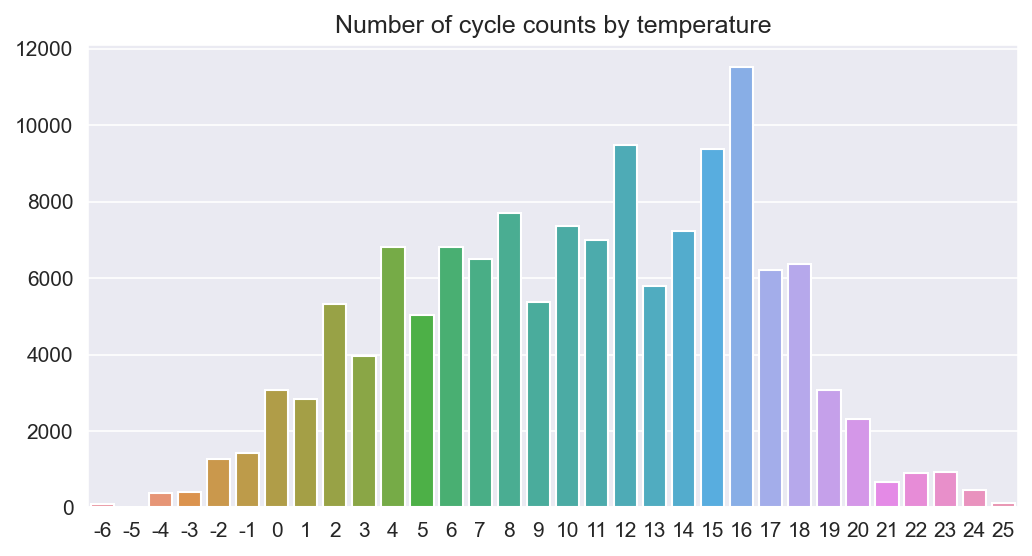

In [22]:
# Lets look at the counts of temperature readings
temp_value_counts = AM_peak_trips['temp_integer'].value_counts()
#To include -5 in the x ticks as there are no values
temp_value_counts.loc[-5]=0
plt.figure(figsize=(8,4), dpi=150)
sns.barplot(x=temp_value_counts.index, y=temp_value_counts.values)
plt.title('Number of cycle counts by temperature')



I will ignore values below -2 and above 20 degrees due to sample sizes. This indicates an increase of approximately 22% in cycle trip numbers over a temperature increase of 22 degrees. 

In [23]:
#How do the numbers of wet and dry days compare?
print(AM_peak_trips['Weather'].value_counts())

0.0    119694
1.0     16074
Name: Weather, dtype: int64


There are more than 7 times as many dry days but we should get a meaningful look at the change in rider numbers on wet weather by plotting against temperature again.

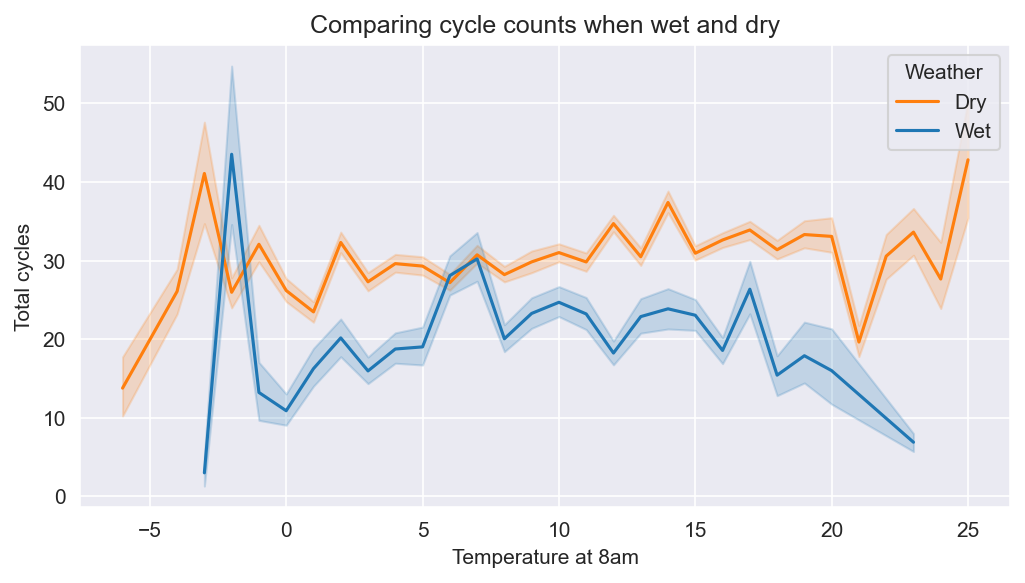

In [43]:
#I'll plot cycle counts for wet and dry days

# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Reverse the order of the first two colors in the list
reversed_first_two_colors = default_palette[:2][::-1] + default_palette[2:]

# Create a Seaborn plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

plt.figure(figsize=(8,4), dpi=150)
plt.title('Comparing cycle counts when wet and dry')

sns.lineplot(x='temp_integer', y='Total cycles', hue= 'Weather', data=AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.legend(title='Weather', loc='upper right')

legend = plt.gca().get_legend()
legend.texts[0].set_text('Dry')
legend.texts[1].set_text('Wet')


Interstingly the wet weather data shows a non-linear response to temperature. Let's take a closer look.

Text(0.5, 0, 'Temperature at 8am')

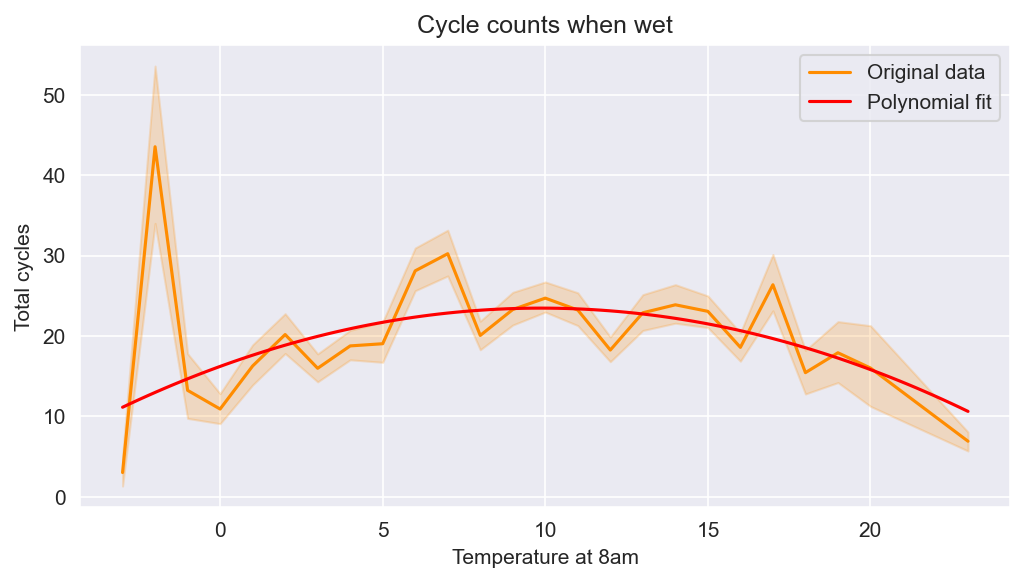

In [46]:


#Select only the rows with 'wet' weather
wet_data = AM_peak_trips[AM_peak_trips['Weather'] == 1]

#Fit a 2nd degree polynomial to the data
coefficients = np.polyfit(wet_data['temp_integer'], wet_data['Total cycles'], 2)

#Create a polynomial function with the found coefficients
poly = np.poly1d(coefficients)

#Generate x values
x_poly = np.linspace(wet_data['temp_integer'].min(), wet_data['temp_integer'].max(), 100)

#Generate y values
y_poly = poly(x_poly)

#Plot the original line plot and the polynomial fit
plt.figure(figsize=(8,4), dpi=150)
plt.title('Cycle counts when wet')
sns.lineplot(x='temp_integer', y='Total cycles', data=wet_data, label='Original data', color='darkorange')
plt.plot(x_poly, y_poly, color='red', label='Polynomial fit')
plt.legend()
plt.xlabel('Temperature at 8am')



A very good fit. At lower temperatures it's understandable that the combination of cold and wet would be more offputting together, but what about at high temperatures? Could it be that the intensity of rain increases, with thunderstorm type rainfall? I'll go back to include the precipitation figure from the weather data.

Text(0, 0.5, 'Precipitation')

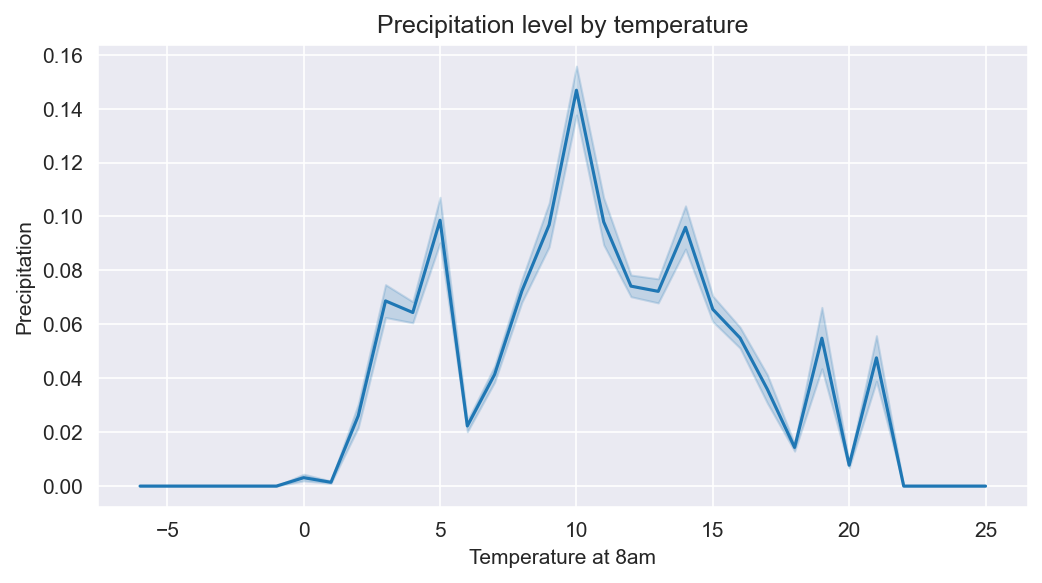

In [47]:
#Let's plot precipitation against temperature for the AM peak

plt.figure(figsize=(8,4), dpi=150)
plt.title('Precipitation level by temperature')
sns.lineplot(x='temp_integer', y='precipitation', data=AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.ylabel('Precipitation')

Preciptation peaks at 10 degrees and drops at higher temps. It could be that wet days when it is hot are not just wet because of precipitation, but also because of perspiration – it's hard not overheat when the weather is hot and humid and not many workplaces have showers. I'll retrieve humidity data from Open Meteo

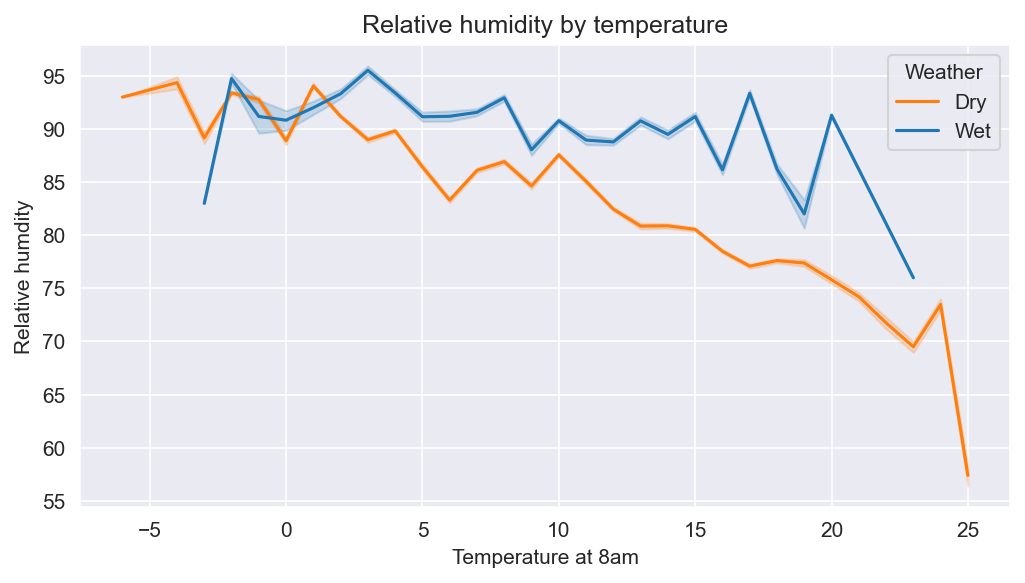

In [36]:
#Plotting humidity against temperature, for wet and dry days

# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Create a Seaborn plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

plt.figure(figsize=(8,4), dpi=150)
plt.title('Relative humidity by temperature')
sns.lineplot(x='temp_integer', y='relative_humidity', hue='Weather', data=AM_peak_trips)
plt.xlabel('Temperature at 8am')
plt.ylabel('Relative humdity')

legend = plt.gca().get_legend()
legend.texts[0].set_text('Dry')
legend.texts[1].set_text('Wet')

That does show a higher humidity on wet days for a given temperature and the difference tends to increase as the temperature increases.

Now let's see if people became 'tougher' once the pandemic started, less sensitive to bad weather out of a desire to avoid taking public transport. I'll take figures from 10 May 2020 as that was when guidance said people who cannot work from home should return to the workplace.


Mean daily Total cycles on dry days: 30.959663809380586
Mean difference in Total cycles on wet and dry days: -11.043112941764086
Percent drop in mean daily Total cycles due to rain: -0.356693567790555


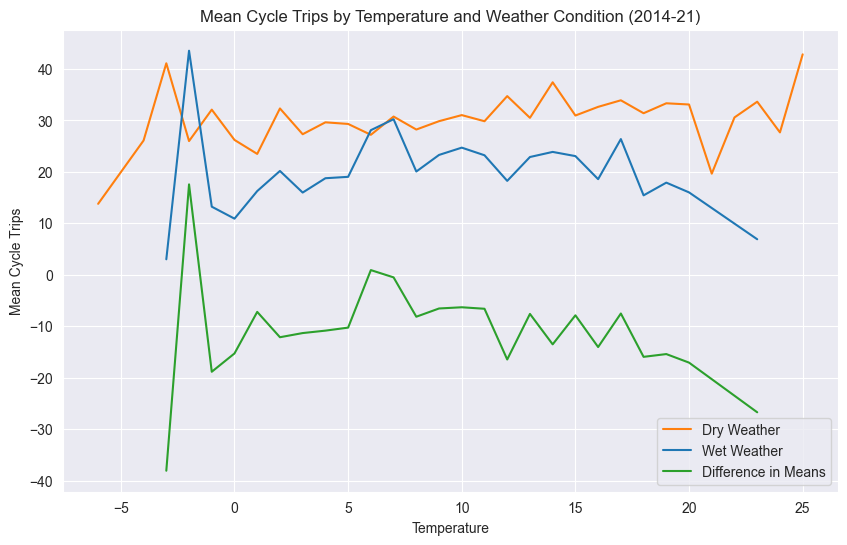

In [37]:

#We'll look at the difference in mean counts of Cycle Trips for wet and dry days with the same temperature
#First for all years

# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Create a Seaborn plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

df_dry = AM_peak_trips[AM_peak_trips['Weather'] == 0]
mean_dry = df_dry.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet = AM_peak_trips[AM_peak_trips['Weather'] == 1]
mean_wet = df_wet.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions
mean_difference = mean_wet.merge(mean_dry, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference['difference'] = mean_difference['Total cycles_wet'] - mean_difference['Total cycles_dry']

#Plotting the results
plt.figure(figsize=(10, 6))

sns.lineplot(x='temp_integer', y='Total cycles', data=mean_dry, label='Dry Weather')
sns.lineplot(x='temp_integer', y='Total cycles', data=mean_wet, label='Wet Weather')

#Difference in means between wet and dry conditions
sns.lineplot(x='temp_integer', y='difference', data=mean_difference, label='Difference in Means')

plt.xlabel('Temperature')
plt.ylabel('Mean Cycle Trips')
plt.title('Mean Cycle Trips by Temperature and Weather Condition (2014-21)')


#Plotting the difference in means does not add much understanding, but a percentage drop in the overall 
# will be useful
dry_mean = np.mean(df_dry['Total cycles'])
mean_difference = np.mean(mean_difference['difference'])
print('Mean daily Total cycles on dry days:', dry_mean)
print('Mean difference in Total cycles on wet and dry days:', mean_difference)
print('Percent drop in mean daily Total cycles due to rain:', mean_difference/dry_mean)

Drop in mean Total cycles on wet days (2019): -12.940595930252002
16688
2338


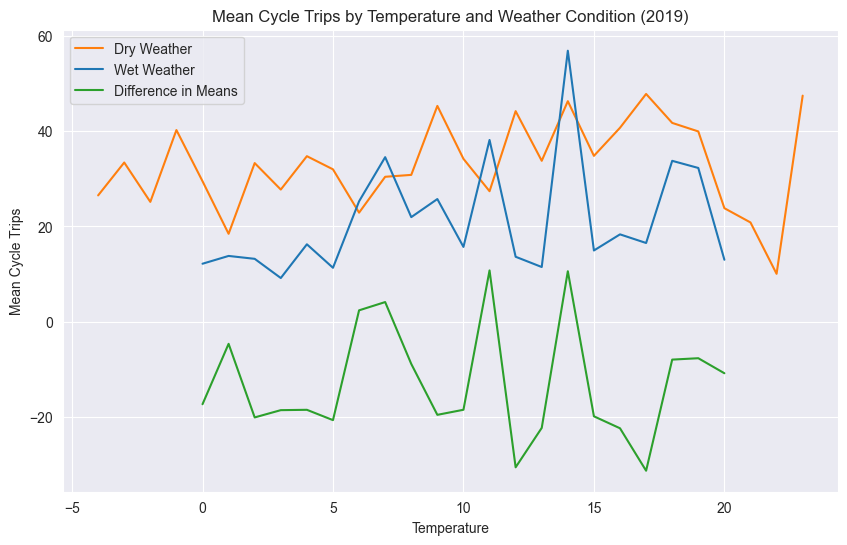

In [38]:
#Then for 2019

# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Create a Seaborn plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

df_dry_2019 = AM_peak_trips[(AM_peak_trips['Weather'] == 0) & (AM_peak_trips['Year'] == 2019)]
mean_dry_2019 = df_dry_2019.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet_2019 = AM_peak_trips[(AM_peak_trips['Weather'] == 1) & (AM_peak_trips['Year'] == 2019)]
mean_wet_2019 = df_wet_2019.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions for 2019
mean_difference_2019 = mean_wet_2019.merge(mean_dry_2019, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference_2019['difference'] = mean_difference_2019['Total cycles_wet'] - mean_difference_2019['Total cycles_dry']

#Plotting the results for 2019
plt.figure(figsize=(10, 6))

sns.lineplot(x='temp_integer', y='Total cycles', data=mean_dry_2019, label='Dry Weather')
sns.lineplot(x='temp_integer', y='Total cycles', data=mean_wet_2019, label='Wet Weather')

#Difference in means between wet and dry conditions for 2019
sns.lineplot(x='temp_integer', y='difference', data=mean_difference_2019, label='Difference in Means')

plt.xlabel('Temperature')
plt.ylabel('Mean Cycle Trips')
plt.title('Mean Cycle Trips by Temperature and Weather Condition (2019)')


mean_of_mean_diff_2019 = np.mean(mean_difference_2019['difference'])
print('Drop in mean Total cycles on wet days (2019):', mean_of_mean_diff_2019)

#I'll check the sample size
print(df_dry_2019['Survey date'].count())
print(df_wet_2019['Survey date'].count())

Drop in mean Total cycles on wet days (2021): -9.95324644140431
12738
1676


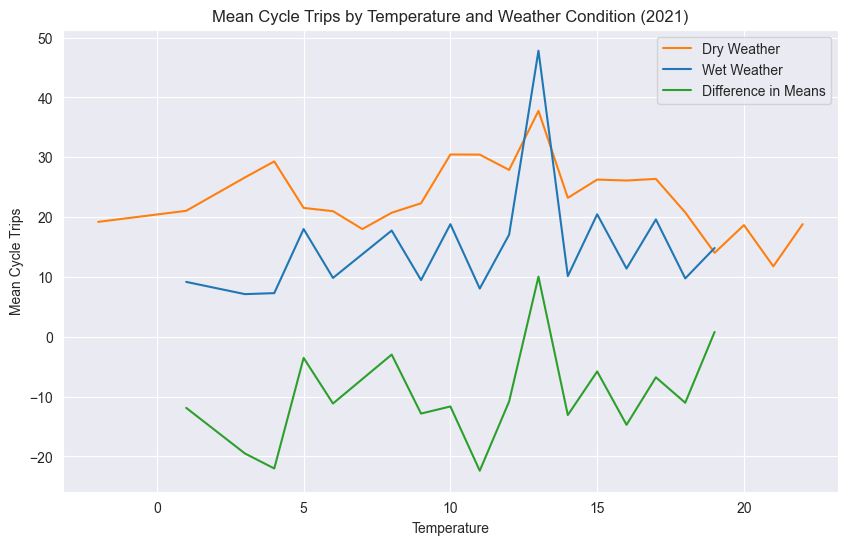

In [39]:
#Then for 2021

# I'll change the colour palette order so that wet days are plotted in blue
default_palette = sns.color_palette()

# Create a Seaborn plot with the reversed palette
sns.set_palette(reversed_first_two_colors)

df_dry_2021 = AM_peak_trips[(AM_peak_trips['Weather'] == 0) & (AM_peak_trips['Year'] == 2021)]
mean_dry_2021 = df_dry_2021.groupby('temp_integer')['Total cycles'].mean().reset_index()

df_wet_2021 = AM_peak_trips[(AM_peak_trips['Weather'] == 1) & (AM_peak_trips['Year'] == 2021)]
mean_wet_2021 = df_wet_2021.groupby('temp_integer')['Total cycles'].mean().reset_index()

#Calculate difference in means between wet and dry conditions for 2021
mean_difference_2021 = mean_wet_2021.merge(mean_dry_2021, on='temp_integer', suffixes=('_wet', '_dry'))
mean_difference_2021['difference'] = mean_difference_2021['Total cycles_wet'] - mean_difference_2021['Total cycles_dry']

#Plotting the results for 2021
plt.figure(figsize=(10, 6))

sns.lineplot(x='temp_integer', y='Total cycles', data=mean_dry_2021, label='Dry Weather')
sns.lineplot(x='temp_integer', y='Total cycles', data=mean_wet_2021, label='Wet Weather')

#Difference in means between wet and dry conditions for 2021
sns.lineplot(x='temp_integer', y='difference', data=mean_difference_2021, label='Difference in Means')

plt.xlabel('Temperature')
plt.ylabel('Mean Cycle Trips')
plt.title('Mean Cycle Trips by Temperature and Weather Condition (2021)')


mean_of_mean_diff_2021 = np.mean(mean_difference_2021['difference'])
print('Drop in mean Total cycles on wet days (2021):', mean_of_mean_diff_2021)

#Check sample size
print(df_dry_2021['Survey date'].count())
print(df_wet_2021['Survey date'].count())

<AxesSubplot: title={'center': 'Comparison of diffence in mean cycle trip counts in wet and dry conditions 2019 + 2021'}, xlabel='Temperature', ylabel='Mean Cycle Trips'>

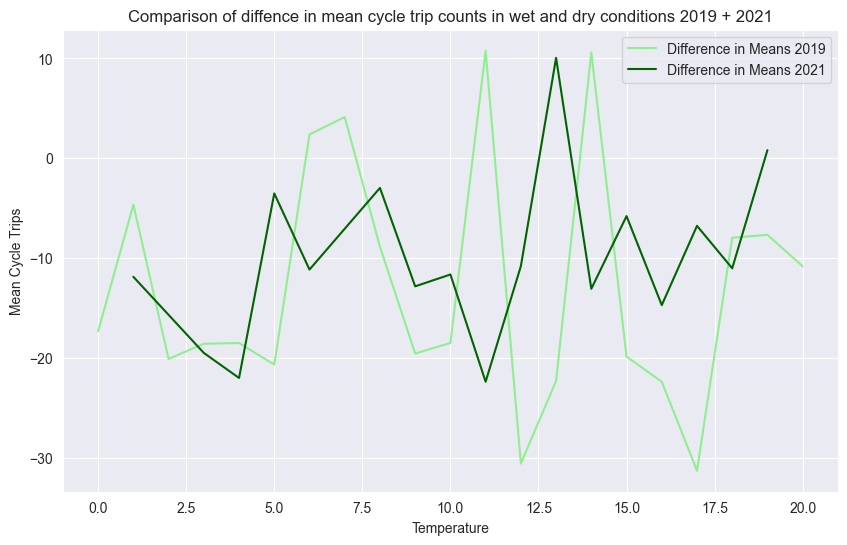

In [52]:
#I'll see what the comparison of differences between wet/dry means in the two years look like

plt.figure(figsize=(10,6))
plt.xlabel('Temperature')
plt.ylabel('Mean Cycle Trips')
plt.title('Comparison of diffence in mean cycle trip counts in wet and dry conditions 2019 + 2021')

sns.lineplot(x='temp_integer', y='difference', data=mean_difference_2019, label='Difference in Means 2019', color='lightgreen')
sns.lineplot(x='temp_integer', y='difference', data=mean_difference_2021, label='Difference in Means 2021', color='darkgreen')



Percentage difference in drop in mean cycle trips due to wet weather: 0.2308509982808432


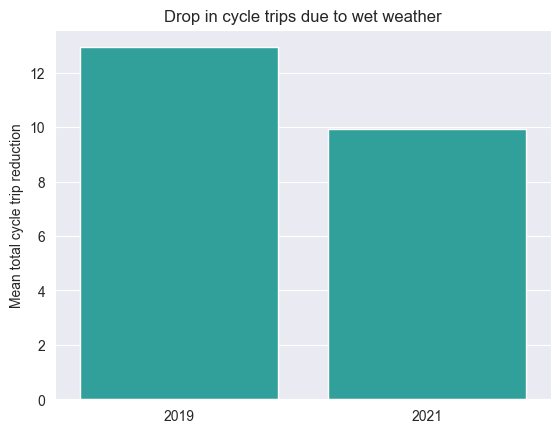

In [53]:

#It's not so easy to see what's going on, so I'll use the means of the difference in means rather than 
#show this comparison

means = [-(mean_of_mean_diff_2019), -(mean_of_mean_diff_2021)]
labels = [2019, 2021]
sns.barplot(x=labels, y=means, color="lightseagreen")
plt.ylabel('Mean total cycle trip reduction')
plt.title('Drop in cycle trips due to wet weather')

print('Percentage difference in drop in mean cycle trips due to wet weather:', 1-mean_of_mean_diff_2021/mean_of_mean_diff_2019)


<AxesSubplot: >

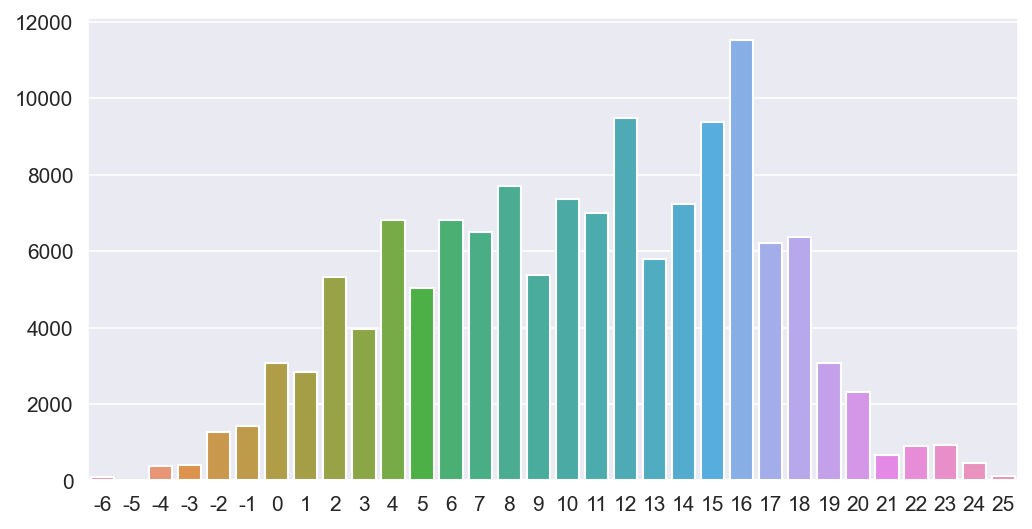

In [52]:
#Lets look at the counts of temperature readings for winter months

winter_AM_peak_trips = AM_peak_trips[AM_peak_trips['Survey date'].dt.month.isin([10,11,12,1,2,3])]

winter_temp_value_counts = winter_AM_peak_trips['temp_integer'].value_counts()
plt.figure(figsize=(8,4), dpi=150)
sns.barplot(x=temp_value_counts.index, y=temp_value_counts.values)

Text(0, 0.5, 'Total cycles (2021)')

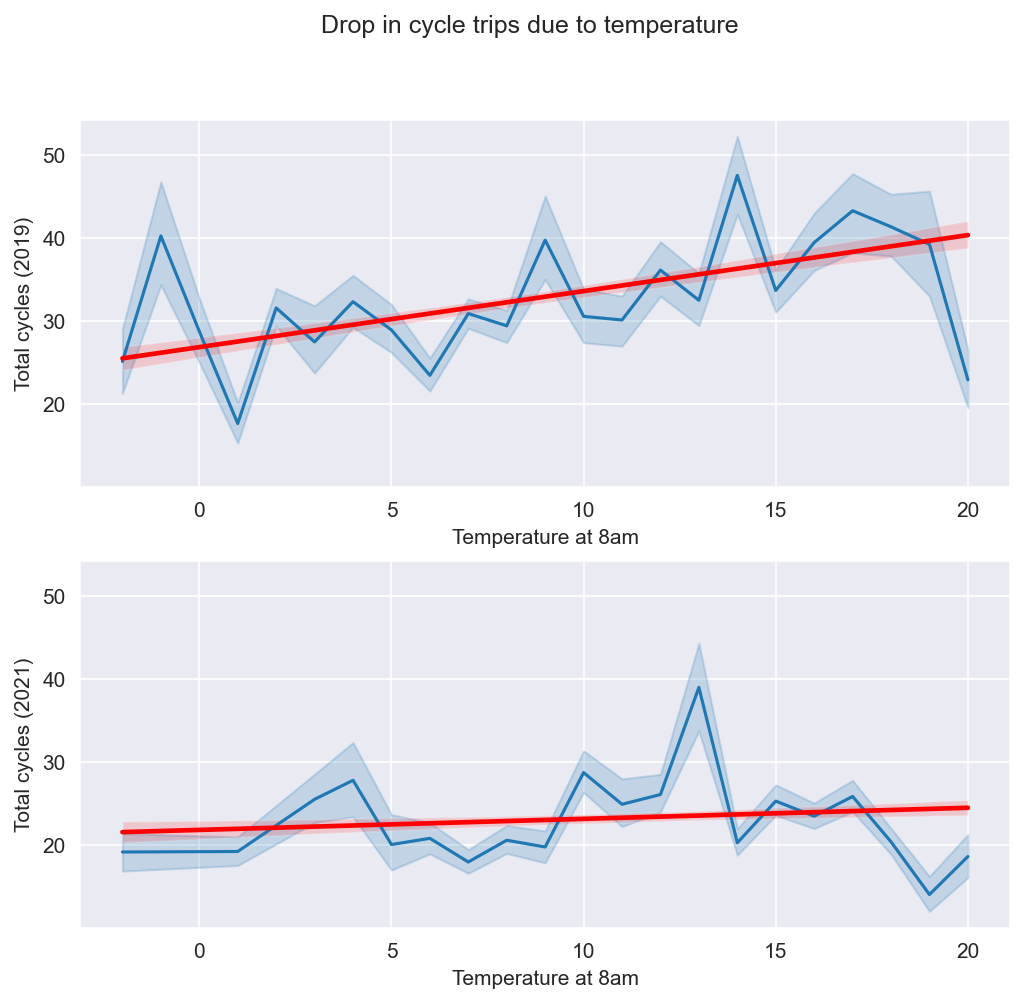

In [54]:
#Plotting differences in the counts of cycle trips by temperature for the two years. 

#Subset dataframe for 2019
df_2019 = AM_peak_trips[AM_peak_trips['Year'] == 2019]

#Subset dataframe for 2021
df_2021 = AM_peak_trips[AM_peak_trips['Year'] == 2021]

#I'll impose the same temperature range as before due to sample sizes in the above barchart

temp_range = range(-2, 21)

df_2019_range = df_2019[df_2019['temp_integer'].isin(temp_range)]
df_2021_range = df_2021[df_2021['temp_integer'].isin(temp_range)]

#Plot the results
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150, sharey=True)
sns.lineplot(x='temp_integer', y='Total cycles', data=df_2019_range, ax=axs[0])
sns.regplot(x='temp_integer', y='Total cycles', data=df_2019_range, scatter=False, color='red', ax=axs[0])
sns.lineplot(x='temp_integer', y='Total cycles', data=df_2021_range, ax=axs[1])
sns.regplot(x='temp_integer', y='Total cycles', data=df_2021_range, scatter=False, color='red', ax=axs[1])

fig.suptitle('Drop in cycle trips due to temperature')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')
axs[0].set_ylabel('Total cycles (2019)')
axs[1].set_ylabel('Total cycles (2021)')



The effect of brown fat. This needs to compare trip counts for the same temperatures as winter starts and as it ends, once the body has adapted to cold exposure.


Text(0, 0.5, 'Total cycles (Jan-Mar)')

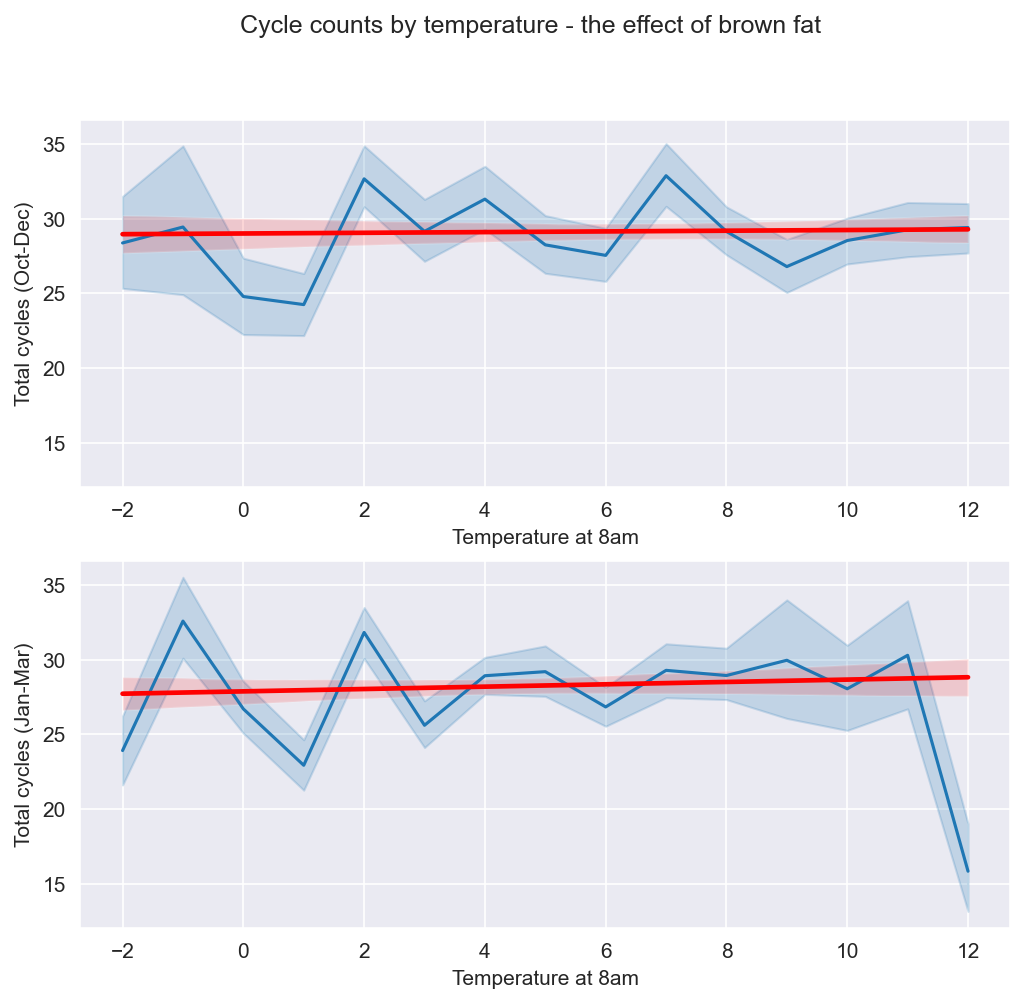

In [46]:
#Subset dataframe for October to December and January to March, dry days. Limited to max of 12 degrees 
#because 12.5 is limit in data for Jan-Mar. Limited to a min of -2 due to sample size, as above

trips_jan_mar = AM_peak_trips[AM_peak_trips['Survey date'].dt.month.isin([1,2,3]) & (AM_peak_trips['Weather'] == 0) & (AM_peak_trips['temp_integer'] >= -2) & (AM_peak_trips['temp_integer'] <= 12)]
trips_oct_dec = AM_peak_trips[AM_peak_trips['Survey date'].dt.month.isin([10,11,12]) & (AM_peak_trips['Weather'] == 0) & (AM_peak_trips['temp_integer'] >= -2) & (AM_peak_trips['temp_integer'] <= 12)]
                              
#Plotting the results

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,7), dpi=150, sharey=True)

sns.lineplot(x='temp_integer', y='Total cycles', data=trips_jan_mar, ax=axs[1])
sns.regplot(x='temp_integer', y='Total cycles', data=trips_jan_mar, scatter=False, color='red', ax=axs[1])
sns.lineplot(x='temp_integer', y='Total cycles', data=trips_oct_dec, ax=axs[0])
sns.regplot(x='temp_integer', y='Total cycles', data=trips_oct_dec, scatter=False, color='red', ax=axs[0])

fig.suptitle('Cycle counts by temperature - the effect of brown fat')
axs[0].set_xlabel('Temperature at 8am')
axs[1].set_xlabel('Temperature at 8am')
axs[0].set_ylabel('Total cycles (Oct-Dec)')
axs[1].set_ylabel('Total cycles (Jan-Mar)')

